In [1]:
#coding:utf-8
%reload_ext autoreload 
%autoreload 2
import os
import sys

project_basedir = '..'
sys.path.append(project_basedir)
from cchess_zero import cbf
from cchess_zero import board_visualizer
from matplotlib import pyplot as plt
import os
from cchess_zero.gameboard import *
from net import resnet
import common
from gameplays import gameplay,players
from gameplays.analysis import get_km_json
import json
%matplotlib inline
gpu_core = 1
import os
from PIL import Image
import imageio
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_core)

/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!date

2018年 10月 24日 星期三 19:18:06 CST


In [3]:
network = resnet.get_model(os.path.join(project_basedir,
    '../data/prepare_weight/2018-10-24_16-50-13_noup'[3:]),
    common.board.create_uci_labels(),GPU_CORE=[gpu_core],FILTERS=128,NUM_RES_LAYERS=7)

0
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
inside res net [None, 10, 9, 128]
INFO:tensorflow:Restoring parameters from ../data/prepare_weight/2018-10-24_16-50-13_noup


# 初始化棋局

In [15]:
HUMAN_FIRST = False
MOVE = 'human' if HUMAN_FIRST else 'computer'

In [16]:
imgs_for_gif = []
state = gameplay.GameState()
statestr = 'RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c1/9/rnbakabnr'
moves = []
#for i in moves[:]: 
#   statestr = GameBoard.sim_do_action(i,statestr)
#   imgs_for_gif.append(board_visualizer.get_board_img(statestr))
#   state.do_moae(i)
#mgs_for_gif = imgs_for_gif[:]
#mageio.mimsave('../data/gif/{}.gif'.format(fname[:-4]), imgs_for_gif,duration=0.5)

# 从这里开始下棋

In [17]:
assert(MOVE in ['human','computer'])
if MOVE == 'human':
    move = input()
    while (move not in GameBoard.get_legal_moves(statestr,current_player=state.currentplayer)):
        print("invalid move {}, please reinput:".format(move))
        move = input()
    MOVE = 'computer'
else:
    network_player = players.NetworkPlayer(state.currentplayer,network,n_playout=1600,
                                           temp_round=-1,repeat_noise=False,c_puct=5,dnoise=True)
    move = network_player.make_move(state=state,actual_move=False)[0]
    MOVE = 'human'
moves.append(move)

b2a2


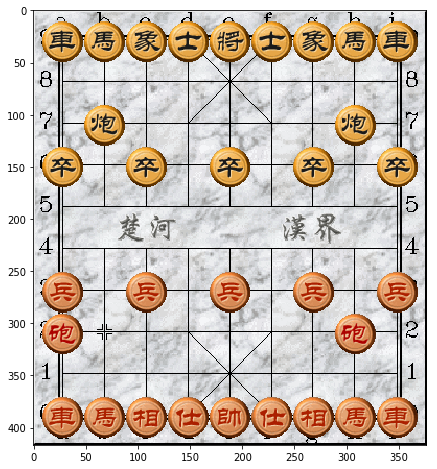

In [18]:
statestr = GameBoard.sim_do_action(move,statestr)
state.do_move(move)
plt.figure(figsize=(8,8))
plt.imshow(board_visualizer.get_board_img(statestr))
print(move)

# analysis

In [19]:
for move in network_player.mcts_policy._root._children:
    node = network_player.mcts_policy._root._children[move]
    print(move,node._n_visits,node._P,node._Q)

a0a1 23 0.00015286448 -0.06776298602293852
a0a2 26 0.00028422894 -0.05220664371378147
a3a4 25 6.300977e-05 -0.014743975666351614
b0a2 32 0.0050150473 0.01826153050024004
b0c2 26 8.4187996e-05 -0.0241892935278324
b2a2 359 0.74546903 -0.012711456795884583
b2c2 123 0.1720034 0.04202496544249749
b2d2 31 0.0185898 0.015695799247271592
b2e2 27 0.002502007 0.02620878102499302
b2f2 28 2.9952611e-05 0.027203842607767512
b2g2 30 3.9310286e-05 0.017109816591255364
b2b1 23 0.00034394872 -0.042833364669881434
b2b3 23 0.0015089024 -0.047854745094968086
b2b4 22 0.0002448727 -0.05174588585611094
b2b5 19 6.280772e-05 -0.05000722650928717
b2b6 21 0.00022136078 -0.04730694967189005
b2b9 34 0.00038389544 0.11200122961514246
c3c4 25 8.796278e-05 -0.009892830224707723
e0e1 23 1.5603035e-05 -0.03867602289613822
e3e4 26 3.5141635e-05 -0.009428426569614273
g3g4 27 3.5663386e-05 -0.008223554740349453
h0g2 30 0.00490442 -0.013246778592777746
h0i2 30 0.0008100409 -0.0003786944415575526
h2c2 28 4.6484558e-05 -0.00

In [18]:
network

((<tensorflow.python.client.session.Session at 0x7f4585754dd8>,
  <tensorflow.python.framework.ops.Graph at 0x7f459196c358>),
 ((<tf.Tensor 'Placeholder:0' shape=(?, 10, 9, 14) dtype=float32>,
   <tf.Tensor 'training_mode:0' shape=<unknown> dtype=bool>),
  (<tf.Tensor 'concat_200:0' shape=(?, 2086) dtype=float32>,
   <tf.Tensor 'concat_201:0' shape=(?, 1) dtype=float32>)))

In [19]:
graph = network[0][1]
sess = network[0][0]

In [20]:
import tensorflow as tf
with graph.as_default():
    regularizer = tf.contrib.layers.l2_regularizer(scale=1e-4)
    regular_variables = tf.trainable_variables()
    l2_loss = tf.contrib.layers.apply_regularization(regularizer, regular_variables)

In [21]:
with graph.as_default():
    print(sess.run(l2_loss))

0.23331022
